- Domestic country
- GEO: Austria
- Holiday and other short-stay accommodation
- Time: 160 months

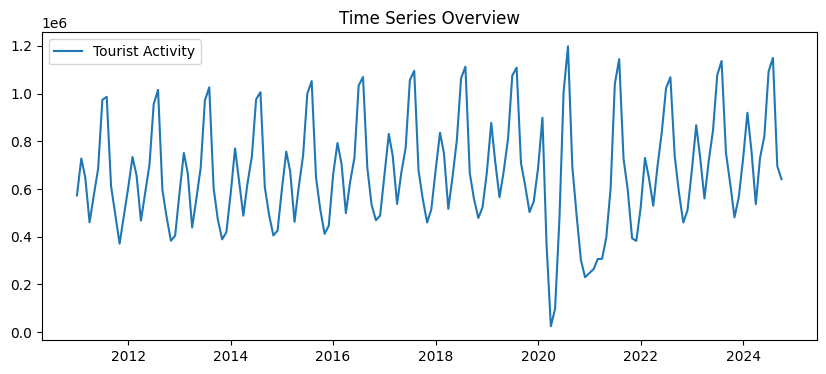

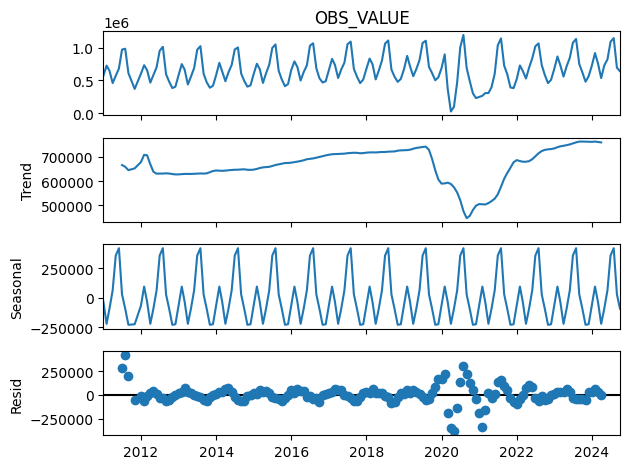

ADF Statistic: -1.6112401818572721
p-value: 0.4773246176606757


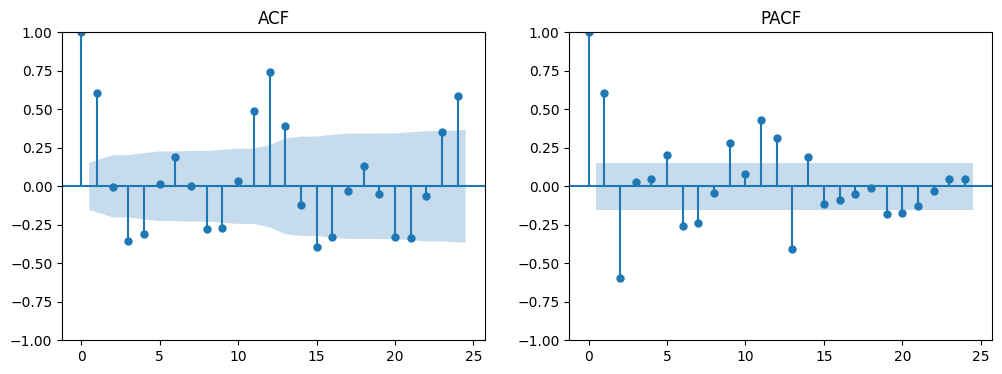

Best Model Order: (2, 1, 2)
Best Seasonal Order: (0, 2, 2, 12)


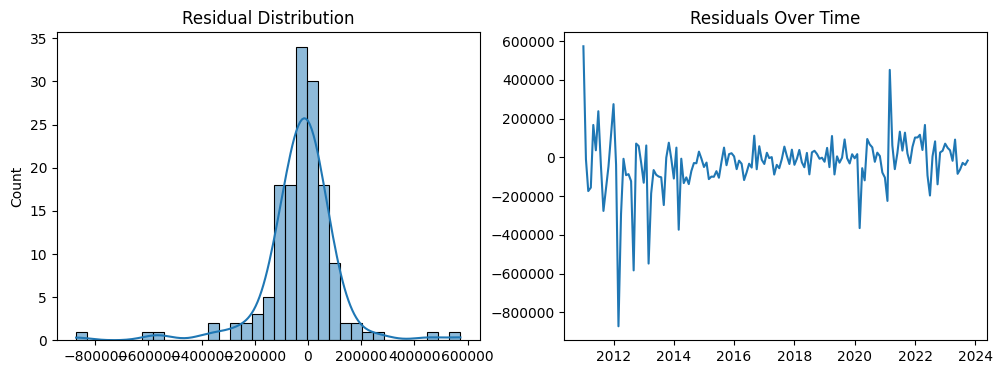

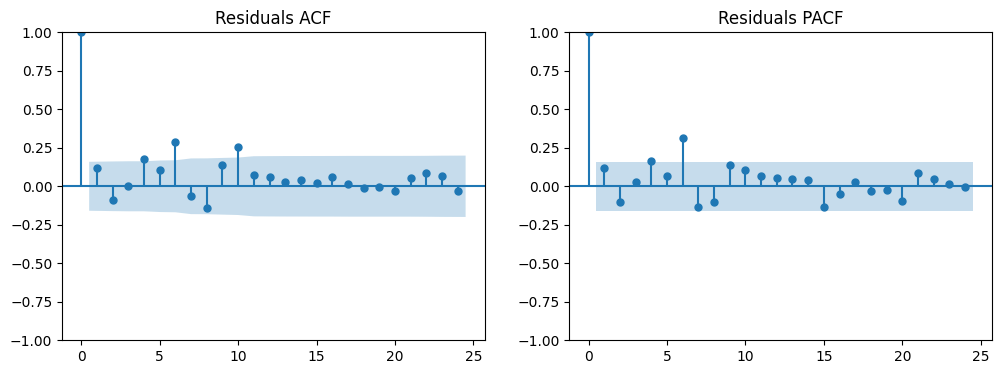

Test MAE: 52817.65590758641
Test RMSE: 63095.339872934055
Test MAPE: 7.017719520027785


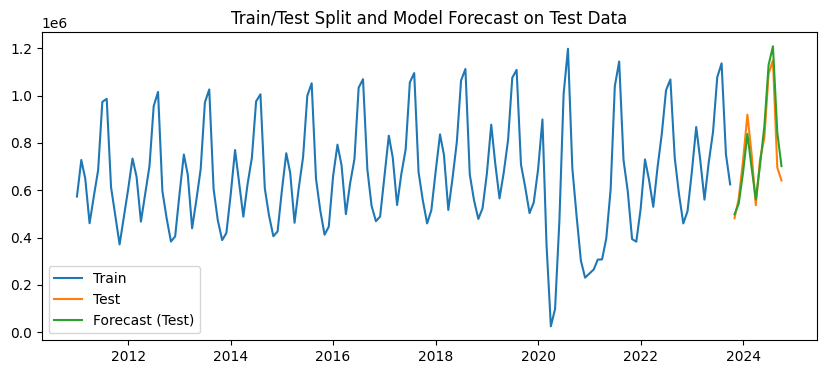

                                     SARIMAX Results                                      
Dep. Variable:                          OBS_VALUE   No. Observations:                  152
Model:             SARIMAX(2, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -1298.708
Date:                            Sun, 26 Jan 2025   AIC                           2611.415
Time:                                    10:49:25   BIC                           2629.652
Sample:                                         0   HQIC                          2618.796
                                            - 152                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1501      0.529      2.175      0.030       0.114       2.186
ar.L2         -0.6355      0.447   

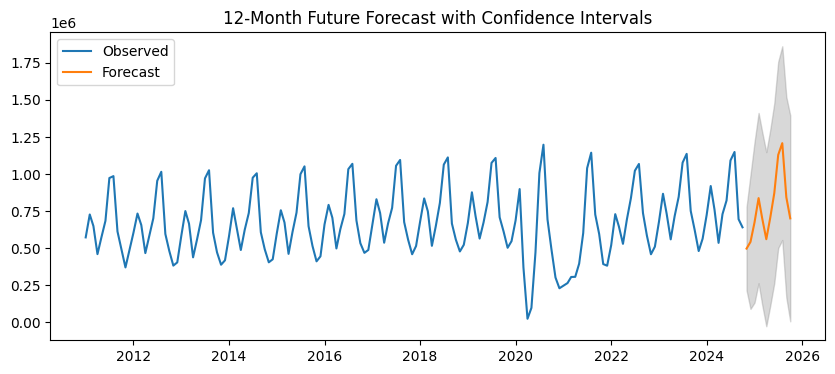

                Forecast       Lower CI      Upper CI
2024-11-01  4.979479e+05  216245.431899  7.796504e+05
2024-12-01  5.429828e+05   91568.686301  9.943970e+05
2025-01-01  6.751170e+05  133909.349547  1.216325e+06
2025-02-01  8.383880e+05  264433.334588  1.412343e+06
2025-03-01  6.998051e+05  116867.214239  1.282743e+06
2025-04-01  5.610900e+05  -25764.467406  1.147945e+06
2025-05-01  7.056977e+05  112728.183677  1.298667e+06
2025-06-01  8.719089e+05  265585.798702  1.478232e+06
2025-07-01  1.129590e+06  501623.265165  1.757556e+06
2025-08-01  1.208639e+06  555539.540358  1.861739e+06
2025-09-01  8.445390e+05  168558.256174  1.520520e+06
2025-10-01  7.017946e+05    7500.122548  1.396089e+06


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_data():
    df = pd.read_csv("DATA/data.csv", index_col=False)
    return df

def preprocess_data(df):
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')
    df.sort_values('TIME_PERIOD', inplace=True)
    df.set_index('TIME_PERIOD', inplace=True)
    return df

def eda(df):
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df['OBS_VALUE'], label='Tourist Activity')
    plt.title("Time Series Overview")
    plt.legend()
    plt.show()

    decomposition = seasonal_decompose(df['OBS_VALUE'], model='additive', period=12)
    decomposition.plot()
    plt.show()

    adf_result = adfuller(df['OBS_VALUE'])
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    plot_acf(df['OBS_VALUE'], ax=ax[0], lags=24, title='ACF')
    plot_pacf(df['OBS_VALUE'], ax=ax[1], lags=24, title='PACF')
    plt.show()

def train_test_split(df, test_size=12):
    return df.iloc[:-test_size], df.iloc[-test_size:]

def sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, m=12):
    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(train, 
                                                order=(p,d,q), 
                                                seasonal_order=(P,D,Q,m),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                results = model.fit(disp=False)
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_model = results
                                    best_order = (p,d,q)
                                    best_seasonal = (P,D,Q,m)
                            except:
                                pass
    return best_model, best_order, best_seasonal

def model_diagnostics(model):
    residuals = model.resid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(residuals, kde=True, ax=ax1)
    ax1.set_title("Residual Distribution")
    ax2.plot(residuals)
    ax2.set_title("Residuals Over Time")
    plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(residuals, ax=ax[0], lags=24, title='Residuals ACF')
    plot_pacf(residuals, ax=ax[1], lags=24, title='Residuals PACF')
    plt.show()

def evaluate_model(model, train, test):
    forecast_obj = model.get_forecast(steps=len(test))
    forecast_mean = forecast_obj.predicted_mean
    forecast_mean.index = test.index
    mae = mean_absolute_error(test, forecast_mean)
    rmse = math.sqrt(mean_squared_error(test, forecast_mean))
    mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
    print("Test MAE:", mae)
    print("Test RMSE:", rmse)
    print("Test MAPE:", mape)
    return forecast_mean

def forecast_future(model, df, steps=12):
    future = model.get_forecast(steps=steps)
    fc_mean = future.predicted_mean
    fc_conf = future.conf_int()
    last_date = df.index[-1]
    future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=steps, freq='MS')
    fc_df = pd.DataFrame({
        "Forecast": fc_mean.values,
        "Lower CI": fc_conf.iloc[:,0].values,
        "Upper CI": fc_conf.iloc[:,1].values
    }, index=future_index)
    return fc_df

def plot_test_forecast(train, test, forecast_test):
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(forecast_test.index, forecast_test, label='Forecast (Test)')
    plt.title("Train/Test Split and Model Forecast on Test Data")
    plt.legend()
    plt.show()

def plot_future_forecast(df, fc_df):
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df['OBS_VALUE'], label='Observed')
    plt.plot(fc_df.index, fc_df['Forecast'], label='Forecast')
    plt.fill_between(fc_df.index, fc_df['Lower CI'], fc_df['Upper CI'], color='gray', alpha=0.3)
    plt.title("12-Month Future Forecast with Confidence Intervals")
    plt.legend()
    plt.show()

def print_progress(text):
    print(text)
    print("=====================================\n")

def main():
    data = load_data()
    
    print_progress("Data Loaded")
    
    data = preprocess_data(data)
    
    print_progress("Data Processed")
    
    eda(data)
    
    print_progress("EDA")

    train, test = train_test_split(data['OBS_VALUE'], test_size=12)
    
    print_progress("Train Test Split")

    p = d = q = range(0,3)
    P = D = Q = range(0,3)
    best_model, best_order, best_seasonal = sarima_grid_search(train, p, d, q, P, D, Q, m=12)
    print("Best Model Order:", best_order)
    print("Best Seasonal Order:", best_seasonal)

    model_diagnostics(best_model)
    forecast_test = evaluate_model(best_model, train, test)
    plot_test_forecast(train, test, forecast_test)

    print(best_model.summary())

    future_fc = forecast_future(best_model, data, steps=12)
    plot_future_forecast(data, future_fc)
    print(future_fc)

if __name__ == "__main__":
    main()


### Výsledek EDA (ADF statistika a p-hodnota)

**Augmented Dickey-Fuller (ADF) test** je statistický test používaný k ověření, zda je časová řada stacionární.

- **ADF statistika**: −1,6112401818572721.
  - Obecně platí, že čím je ADF statistika více záporná, tím silnější důkazy máme proti nulové hypotéze nestacionarity.

- **P-hodnota**: 0,4773246176606757.
  - Tato hodnota je vyšší než typické prahové hodnoty (např. 0,05 nebo 0,01), což znamená, že nemůžeme zamítnout nulovou hypotézu o nestacionaritě.

Z toho vyplývá, že časová řada pravděpodobně obsahuje jednotkový kořen a je nestacionární. Nestacionarita se obvykle projevuje přítomností trendů, sezónních vzorců nebo jiných struktur, které se nemění v čase.

**Další úvahy**:

1. **Transformace dat**:
    - V případě nestacionarity je často nutné provést diferencování pro dosažení stacionarity.
    - Silné sezónní složky mohou maskovat stacionaritu, což může částečně vysvětlit vysokou p-hodnotu.

2. **Velikost vzorku**:
    - ADF test může být neprůkazný, pokud je velikost vzorku malá nebo pokud jsou přítomny složité sezónní složky.

3. **Vizualizace dat**:
    - Základní vizualizace časové řady odhalila zřetelné trendy a opakující se sezónní vrcholy, což potvrzuje nestacionaritu.
    - Tyto grafy mohou také ukázat přítomnost náhlých změn nebo odlehlých hodnot.

4. **Modelování nestacionárních dat**:
    - Např. modely SARIMAX mohou být vhodné, pokud správně zohlední nestacionaritu a sezónní vlivy.

---

### ACF vypadá sinusoidálně, PACF je také sinusoidální, ale tlumený

- **ACF (autokorelační funkce)**:
  - Měří, jak současné hodnoty časové řady souvisejí s jejími minulými hodnotami při různých zpožděních.
  - Sinusoidální vzor v ACF často naznačuje přítomnost silné sezónnosti nebo cyklického chování v čase.
  - Pokud ACF nekonverguje rychle k nule, naznačuje to přetrvávající korelace napříč více zpožděními běžné u sezónních dat.

- **PACF (parciální autokorelační funkce)**:
  - Ukazuje korelaci s daným zpožděním po zohlednění vlivu mezilehlých zpoždění.
  - Sinusoidální vzor v PACF naznačuje komplexní interakce, kde každé zpoždění má částečnou korelaci, která se časem snižuje.

- **Význam sinusoidálních vzorů**:
  - Sinusoidální ACF může znamenat dobře definovaný sezónní cyklus, což znamená, že časová řada silně koreluje se sebou samou v sezónních intervalech.
  - Tlumené sinusoidální PACF naznačuje, že vliv zpožděných hodnot existuje, ale postupně klesá.

---

**Praktické důsledky**:

1. **Modelování sezónních složek**:
    - Cyklické vzory v ACF/PACF naznačují potřebu více než jedné sezónní diferenciace.

2. **Sezónní vlivy**:
    - V reálných datech z oblasti cestovního ruchu jsou cyklické vzory spojeny s obdobími dovolených, změnami počasí a ekonomickými cykly.

3. **Vliv na rezidua**:
    - Špatně zohledněná sezónnost často zanechává vysokou autokorelaci v reziduích, což naznačuje nedostatečný model.
    - Sinusoidální vzory v ACF/PACF u měsíčních dat vedou k vrcholům přibližně na 12 zpožděních, což odpovídá ročnímu cyklu.

4. **Modelová doporučení**:
    - Tyto vzory potvrzují, že konečný model by měl zahrnovat odpovídající sezónní diferenciaci nebo sezónní AR/MA parametry.

---

### Nejlepší nalezený model: SARIMAX(2, 1, 2)x(0, 2, 2, 12)

SARIMAX znamená **Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors**, přestože v tomto případě nejsou zahrnuty exogenní proměnné.

**Parametry modelu:**

- **(p, d, q)**: nestacionární část
  - **p = 2**: model zahrnuje dva autoregresní členy.
  - **d = 1**: jedna úroveň diferenciace.
  - **q = 2**: dva členy klouzavého průměru.

- **(P, D, Q, m)**: sezónní část
  - **P = 0**: žádné dodatečné sezónní autoregresní členy.
  - **D = 2**: dvakrát sezónně diferencovaná řada.
  - **Q = 2**: dva sezónní členy klouzavého průměru.
  - **m = 12**: měsíční cyklus.

---

**Význam parametrů**:

1. **Nestacionarita**:
    - Dvě sezónní diferenciace (D=2) ukazují, že data vyžadovala silný přístup ke snížení sezónní nestacionarity, což je konzistentní s výsledky EDA.

2. **Autoregresní a MA členy**:
    - Přítomnost autoregresních členů (p=2) naznačuje, že minulé hodnoty jsou významně prediktivní.
    - Dva sezónní členy klouzavého průměru (Q=2) naznačují přetrvávající sezónní šoky.

3. **Optimalizace modelu**:
    - Tento model byl nalezen na základě minimalizace AIC, což je metrika vyvažující kvalitu přizpůsobení modelu a jeho složitost.

---

### Distribuce reziduí a fluktuace

- **Distribuce reziduí**:
  - Rezidua vykazují přibližně gaussovské rozdělení (ve tvaru zvonu) centrované kolem nuly.
  - Největší fluktuace byly zaznamenány kolem roku 2012 (nevim) a 2021 (covid).

- **Heteroskedasticita**:
  - Stabilita rozptylu reziduí v čase, mimo speciální šoky, naznačuje homoskedasticitu (stejnorodost rozptylu), což je důležité pro modely ARIMA.

- **Normalita reziduí**:
  - Testy jako Shapiro-Wilk mohou potvrdit, že rezidua jsou přibližně normální, přestože Jarque-Bera naznačuje odchylky.

---

### Interpretace souhrnných statistik (Ljung-Box, Jarque-Bera, heteroskedasticita, skew, kurtosis)

1. **Ljung-Box**:
    - Q-statistika = 0,01, p-hodnota = 0,94.
    - Nemůžeme zamítnout nulovou hypotézu, že rezidua nevykazují autokorelaci na zpoždění 1. To znamená, že rezidua se chovají jako bílý šum.

2. **Jarque-Bera**:
    - Statistika = 251,64, p-hodnota = 0,00.
    - Zamítáme nulovou hypotézu normality reziduí, což naznačuje odchylky (pravděpodobně v oblastech s extrémními hodnotami).

3. **Heteroskedasticita**:
    - H = 5,37, p-hodnota = 0,00.
    - Variance reziduí není konstantní (heteroskedasticita).
    - pro heteroskedacitiu je vhodné využít např. model GARCH.

4. **Skew a kurtosis**:
    - **Skew = 0,49**: rezidua jsou mírně vychýlená doprava.
    - **Kurtosis = 10,71**: vysoká hodnota naznačuje extrémní odlehlé hodnoty.

---

Celkově výsledky ukazují, že:

- Rezidua mají malou autokorelaci (to je dobře).
- Objevují se problémy s nestandardní distribucí (důležité pro odhady intervalů).
- Model je dobře nastaven pro bodové predikce, ale může vyžadovat dodatečné úpravy pro lepší intervalové odhady.

